Thanks to: <br>
https://github.com/soumyac1999/FGSM-Keras, <br>
           https://github.com/YunYang1994/TensorFlow2.0-Examples, <br>
           https://www.tensorflow.org/beta/tutorials/generative/adversarial_fgsm

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import cv2

## importing an image

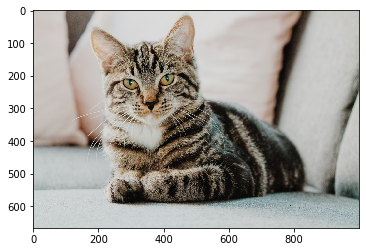

In [2]:
im = cv2.imread("cat.jpeg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)  
plt.imshow(im)
plt.show()

## preprosessing the image:

In [3]:
im = cv2.resize(im, dsize=(224,224))
image = tf.keras.applications.mobilenet_v2.preprocess_input(im)
expanded_image = np.expand_dims(image, axis=0) # needed to be inputted to the model

## Importing Mobilenet model on imagenet dataset:

In [4]:
model = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet')

## Finding out the label of the image:

In [5]:
labels = model.predict(expanded_image)
print(tf.keras.applications.mobilenet_v2.decode_predictions(labels,top=3)[0])

[('n02123159', 'tiger_cat', 0.5283619), ('n02123045', 'tabby', 0.36492294), ('n02124075', 'Egyptian_cat', 0.017658347)]


## Choosing tiger cat as the label, building the corresponding one-hot vector:

In [6]:
actual_label_onehot = np.eye(1000)[labels.argmax()].astype(np.float32).reshape(-1,1000)

## Calculating the gradient with respect to the image:

In [7]:
tf_image = tf.convert_to_tensor(expanded_image) # input of tf.GradientTape must be a tensor
with tf.GradientTape() as tape:
    tape.watch(tf_image)
    prediction = model(tf_image) # output of the model must be a tensor, thats why
    #model.predict is not used.
    loss = tf.keras.losses.categorical_crossentropy(actual_label_onehot, prediction)

gradients = tape.gradient(loss, tf_image) # automatic derivate of loss w.r.t. the input
gradients.shape

W0713 19:47:50.985640 4679730624 deprecation.py:323] From /Users/john/anaconda3/envs/tf2/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1220: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


TensorShape([1, 224, 224, 3])

In [8]:
np_gradients = gradients.numpy() 

## Adversarial Attack:

In [9]:
np_gradients_signed = np.sign(np_gradients)
np_gradients_signed *= 0.1 #using 0.1 to be visually distinguishable

In [10]:
adv_image = expanded_image + np_gradients_signed

# Real Image prediction results:

In [11]:
y = model.predict(expanded_image)
print(tf.keras.applications.mobilenet_v2.decode_predictions(y,
      top=3)[0])

[('n02123159', 'tiger_cat', 0.5283619), ('n02123045', 'tabby', 0.36492294), ('n02124075', 'Egyptian_cat', 0.017658347)]


# new image prediction results:

In [12]:
y = model.predict(adv_image)
print(tf.keras.applications.mobilenet_v2.decode_predictions(y,
      top=3)[0])

[('n02123045', 'tabby', 0.76710665), ('n02124075', 'Egyptian_cat', 0.05869367), ('n02123159', 'tiger_cat', 0.046536867)]


## Drawing images:

In [13]:
intact = expanded_image
adv = adv_image
gra = np_gradients_signed
# resacaling to 0 .. 255 
i = np.interp(intact, (intact.min(), intact.max()), (0, 255)).astype(np.int)
a = np.interp(adv_image, (adv_image.min(), adv_image.max()), (0, 255)).astype(np.int)
g = np.interp(gra, (gra.min(), gra.max()),(0,255)).astype(np.int)
ii = np.squeeze(i)
aa = np.squeeze(a)
gg = np.squeeze(g)

# Real Image

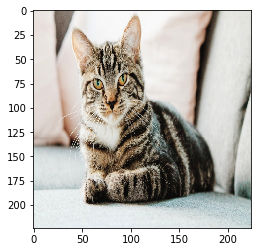

In [14]:
plt.imshow(ii)
plt.show()

# Attacked image

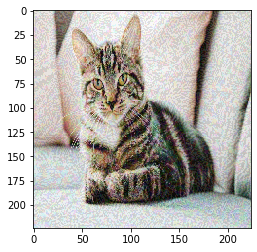

In [15]:
plt.imshow(aa)
plt.show()

# Noise added:

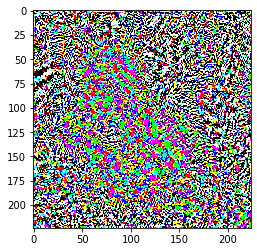

In [16]:
plt.imshow(gg)
plt.show()

#### model(image) vs. model.predict(image)  : 
####    model(image) outputs a tensor
####    model.predict(image) outputs a numpy array

In [17]:
model(expanded_image)[0][0]

<tf.Tensor: id=9321, shape=(), dtype=float32, numpy=3.3983204e-05>

In [18]:
model.predict(expanded_image)[0][0]

3.3983204e-05